In [1]:
# Install required packages
!pip install mne pyriemann scikit-learn matplotlib seaborn pandas numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 6.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# MNE imports
import mne
from mne import Annotations
from mne.decoding import Vectorizer

# Scikit-learn imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pyriemann imports
from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn

# Set random seed for reproducibility
np.random.seed(42)

Mounted at /content/drive


In [3]:
# Configure paths (adjust according to your setup)
data_path = '/content/drive/MyDrive/Colab Notebooks/EEG_analysis/processed_data/'
train_features_path = data_path + "concatenated_train_final_data_epoch_final.csv"
train_labels_path = data_path + "train_labels.csv"
test_features_path = data_path + "concatenated_test_final_data_epoch_final.csv"
test_labels_path = data_path + "test_labels.csv"

In [31]:
def load_and_preprocess_data(features_path, labels_path, sfreq=256, start_sample=768):
    """
    Load and preprocess EEG data for P300 classification
    """
    print(f"Loading data from {features_path}...")

    # Load data
    X_raw = pd.read_csv(features_path, header=None).values
    y = pd.read_csv(labels_path, header=None).values.flatten()

    print(f"Raw data shape: {X_raw.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Class distribution: {np.bincount(y.astype(int))}")

    # Trim data from specified start sample
    if start_sample > 0 and start_sample < X_raw.shape[1]:
        X_raw = X_raw[:, start_sample:]
        print(f"Trimmed data from sample {start_sample}, new shape: {X_raw.shape}")

    # Reshape for MNE format: [n_trials, n_channels, n_timepoints]
    # Assuming single channel EEG
    X = X_raw[:, np.newaxis, :]

    # Check data range and keep original units to avoid MNE scaling issues
    data_range = np.abs(X).max()
    print(f"Data range: {X.min():.6f} to {X.max():.6f}")
    print(f"Data std: {X.std():.6f}")

    # Don't scale the data - let MNE handle it as-is to avoid unit confusion
    print("Keeping original data scaling to avoid MNE unit issues")

    print(f"Final preprocessed data shape: {X.shape}")

    return X, y

# Load training data
X_train, y_train = load_and_preprocess_data(train_features_path, train_labels_path)

# Load test data
X_test, y_test = load_and_preprocess_data(test_features_path, test_labels_path)

Loading data from /content/drive/MyDrive/Colab Notebooks/EEG_analysis/processed_data/concatenated_train_final_data_epoch_final.csv...
Raw data shape: (4456, 1280)
Labels shape: (4456,)
Class distribution: [2242 2214]
Trimmed data from sample 768, new shape: (4456, 512)
Data range: -148.947170 to 141.539950
Data std: 64.270892
Keeping original data scaling to avoid MNE unit issues
Final preprocessed data shape: (4456, 1, 512)
Loading data from /content/drive/MyDrive/Colab Notebooks/EEG_analysis/processed_data/concatenated_test_final_data_epoch_final.csv...
Raw data shape: (1114, 1280)
Labels shape: (1114,)
Class distribution: [543 571]
Trimmed data from sample 768, new shape: (1114, 512)
Data range: -181.890430 to 168.611020
Data std: 64.120343
Keeping original data scaling to avoid MNE unit issues
Final preprocessed data shape: (1114, 1, 512)


In [32]:
def create_mne_epochs(X, y, sfreq=256, tmin=0, tmax=None):
    """
    Create MNE Epochs object from numpy arrays
    """
    n_trials, n_channels, n_timepoints = X.shape

    if tmax is None:
        tmax = (n_timepoints - 1) / sfreq

    # Create MNE info structure
    ch_names = ['EEG'] if n_channels == 1 else [f'EEG_{i+1}' for i in range(n_channels)]
    ch_types = ['eeg'] * n_channels
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create events array for MNE
    events = np.zeros((n_trials, 3), dtype=int)
    events[:, 0] = np.arange(n_trials) * n_timepoints  # Sample indices
    events[:, 2] = y.astype(int) + 1  # Event IDs (1 for class 0, 2 for class 1)

    # Event dictionary
    event_id = {'Non-Target': 1, 'Target': 2}

    # Concatenate all trials into continuous data
    continuous_data = X.transpose(1, 0, 2).reshape(n_channels, -1)

    # Create Raw object
    raw = mne.io.RawArray(continuous_data, info)

    # Create epochs
    epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax,
                       baseline=None, preload=True, verbose=False)

    return epochs

# Create MNE epochs objects
epochs_train = create_mne_epochs(X_train, y_train)
epochs_test = create_mne_epochs(X_test, y_test)

print(f"Training epochs: {epochs_train}")
print(f"Test epochs: {epochs_test}")

Creating RawArray with float64 data, n_channels=1, n_times=2281472
    Range : 0 ... 2281471 =      0.000 ...  8911.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=570368
    Range : 0 ... 570367 =      0.000 ...  2227.996 secs
Ready.
Training epochs: <Epochs | 4456 events (all good), 0 – 1.996 s (baseline off), ~17.4 MiB, data loaded,
 'Non-Target': 2242
 'Target': 2214>
Test epochs: <Epochs | 1114 events (all good), 0 – 1.996 s (baseline off), ~4.4 MiB, data loaded,
 'Non-Target': 543
 'Target': 571>


In [33]:
def apply_preprocessing(epochs, l_freq=0.5, h_freq=30.0, baseline_correction=True,
                      artifact_rejection=False, manual_outlier_removal=True):
    """
    Apply preprocessing to epochs without MNE's artifact rejection
    """
    epochs_processed = epochs.copy()

    # Apply bandpass filter (typical for P300: 0.5-30 Hz)
    print(f"Applying bandpass filter: {l_freq}-{h_freq} Hz")
    epochs_processed.filter(l_freq=l_freq, h_freq=h_freq, verbose=False)

    # Apply baseline correction with proper handling
    if baseline_correction:
        # Calculate baseline period (first 10% of epoch or first 100ms, whichever is smaller)
        epoch_duration = epochs.times[-1] - epochs.times[0]
        baseline_duration = min(0.1, epoch_duration * 0.1)  # Fixed: use min of 100ms or 10% of epoch

        if epoch_duration > baseline_duration:
            baseline = (epochs.times[0], epochs.times[0] + baseline_duration)
            print(f"Applying baseline correction: {baseline[0]:.3f} to {baseline[1]:.3f} s")
            epochs_processed.apply_baseline(baseline, verbose=False)
        else:
            print(f"Epoch too short for baseline correction (duration: {epoch_duration:.3f}s)")
            print("Skipping baseline correction...")

    epochs_before = len(epochs_processed)

    # Manual outlier removal (more reliable than MNE's artifact rejection)
    if manual_outlier_removal:
        print("Performing manual outlier detection...")

        # Get the data
        data = epochs_processed.get_data()  # Shape: [n_epochs, n_channels, n_times]

        # Calculate various metrics for outlier detection
        peak_to_peak = np.ptp(data, axis=2)  # Peak-to-peak per epoch
        variance = np.var(data, axis=2)      # Variance per epoch
        max_abs = np.max(np.abs(data), axis=2)  # Maximum absolute value per epoch

        # Define outlier criteria (more lenient than MNE)
        p99_ptp = np.percentile(peak_to_peak, 99)    # 99th percentile of peak-to-peak
        p99_var = np.percentile(variance, 99)        # 99th percentile of variance
        p99_max = np.percentile(max_abs, 99)         # 99th percentile of max absolute

        print(f"Outlier thresholds - P2P: {p99_ptp:.1f}, Var: {p99_var:.1f}, Max: {p99_max:.1f}")

        # Identify outliers (epochs that exceed ALL thresholds)
        outliers = (
            (peak_to_peak.squeeze() > p99_ptp) &
            (variance.squeeze() > p99_var) &
            (max_abs.squeeze() > p99_max)
        )

        n_outliers = np.sum(outliers)

        if n_outliers > 0:
            print(f"Found {n_outliers} outlier epochs (keeping {epochs_before - n_outliers} epochs)")

            # Create a selection of good epochs
            good_epochs = ~outliers

            # Extract good epochs manually
            good_indices = np.where(good_epochs)[0]
            epochs_processed = epochs_processed[good_indices]
        else:
            print("No outlier epochs detected")

    # Skip MNE's artifact rejection entirely since it's causing issues
    if artifact_rejection:
        print("Note: Skipping MNE artifact rejection due to data scaling issues")

    epochs_after = len(epochs_processed)
    print(f"Final epochs after preprocessing: {epochs_after} (removed {epochs_before - epochs_after} epochs)")

    return epochs_processed

# Apply preprocessing
epochs_train_clean = apply_preprocessing(epochs_train)
epochs_test_clean = apply_preprocessing(epochs_test)

# Get preprocessed data
X_train_clean = epochs_train_clean.get_data()
y_train_clean = epochs_train_clean.events[:, 2] - 1  # Convert back to 0/1

X_test_clean = epochs_test_clean.get_data()
y_test_clean = epochs_test_clean.events[:, 2] - 1

Applying bandpass filter: 0.5-30.0 Hz
Applying baseline correction: 0.000 to 0.100 s
Performing manual outlier detection...
Outlier thresholds - P2P: 283.4, Var: 5108.2, Max: 208.2
Found 3 outlier epochs (keeping 4453 epochs)
Final epochs after preprocessing: 4453 (removed 3 epochs)
Applying bandpass filter: 0.5-30.0 Hz
Applying baseline correction: 0.000 to 0.100 s
Performing manual outlier detection...
Outlier thresholds - P2P: 281.9, Var: 5038.1, Max: 206.7
No outlier epochs detected
Final epochs after preprocessing: 1114 (removed 0 epochs)


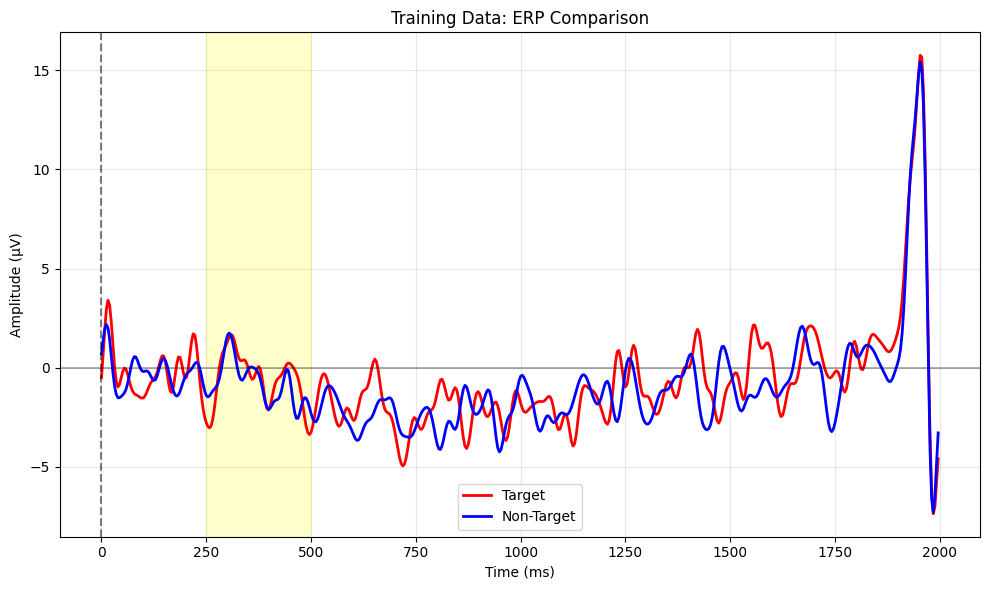

P300 amplitude: 2.28 µV
P300 latency: 465 ms


In [34]:
def plot_erp_comparison(epochs, title="ERP Comparison"):
    """
    Plot ERP comparison between Target and Non-Target
    """
    # Get data for each condition
    target_data = epochs['Target'].get_data().mean(axis=0).squeeze()
    non_target_data = epochs['Non-Target'].get_data().mean(axis=0).squeeze()

    # Create time vector
    times = epochs.times * 1000  # Convert to milliseconds

    plt.figure(figsize=(10, 6))
    plt.plot(times, target_data, label='Target', linewidth=2, color='red')
    plt.plot(times, non_target_data, label='Non-Target', linewidth=2, color='blue')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Stimulus onset')

    # Highlight P300 window (typically 250-500 ms)
    plt.axvspan(250, 500, alpha=0.2, color='yellow', label='P300 window')

    plt.tight_layout()
    plt.show()

    # Calculate difference wave
    diff_wave = target_data - non_target_data
    p300_window = (times >= 250) & (times <= 500)
    p300_amplitude = np.max(diff_wave[p300_window])
    p300_latency = times[p300_window][np.argmax(diff_wave[p300_window])]

    print(f"P300 amplitude: {p300_amplitude:.2f} µV")
    print(f"P300 latency: {p300_latency:.0f} ms")

# Plot ERPs
plot_erp_comparison(epochs_train_clean, "Training Data: ERP Comparison")

In [35]:
def create_improved_pipelines():
    """
    Create improved classification pipelines with better hyperparameters
    """
    pipelines = OrderedDict()

    # 1. Vectorization + Logistic Regression (improved)
    pipelines['Vect + LR'] = make_pipeline(
        Vectorizer(),
        StandardScaler(),
        LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    )

    # 2. Vectorization + Regularized LDA (improved)
    pipelines['Vect + RegLDA'] = make_pipeline(
        Vectorizer(),
        LDA(shrinkage='auto', solver='eigen')
    )

    # 3. Xdawn + Vectorization + LDA (improved)
    pipelines['Xdawn + RegLDA'] = make_pipeline(
        Xdawn(nfilter=4, classes=[1], estimator='lwf'),  # More filters, better estimator
        Vectorizer(),
        LDA(shrinkage='auto', solver='eigen')
    )

    # 4. ERPCovariances + Tangent Space (improved)
    pipelines['ERPCov + TS'] = make_pipeline(
        ERPCovariances(classes=[1], estimator='lwf'),  # Ledoit-Wolf estimator
        TangentSpace(metric='riemann'),
        LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    )

    # 5. ERPCovariances + MDM (improved)
    pipelines['ERPCov + MDM'] = make_pipeline(
        ERPCovariances(classes=[1], estimator='lwf'),
        MDM(metric='riemann')
    )

    # 6. XdawnCovariances + Tangent Space (advanced)
    pipelines['XdawnCov + TS'] = make_pipeline(
        XdawnCovariances(nfilter=4, classes=[1], estimator='lwf'),
        TangentSpace(metric='riemann'),
        LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    )

    # 7. Vectorization + SVM (new)
    pipelines['Vect + SVM'] = make_pipeline(
        Vectorizer(),
        StandardScaler(),
        SVC(C=1.0, gamma='scale', probability=True, random_state=42)
    )

    # 8. Vectorization + Random Forest (new)
    pipelines['Vect + RF'] = make_pipeline(
        Vectorizer(),
        StandardScaler(),
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    )

    return pipelines

# Create pipelines
pipelines = create_improved_pipelines()
print(f"Created {len(pipelines)} classification pipelines:")
for name in pipelines.keys():
    print(f"  - {name}")

Created 8 classification pipelines:
  - Vect + LR
  - Vect + RegLDA
  - Xdawn + RegLDA
  - ERPCov + TS
  - ERPCov + MDM
  - XdawnCov + TS
  - Vect + SVM
  - Vect + RF


In [36]:
def evaluate_pipelines(pipelines, X, y, cv_splits=10, test_size=0.25, random_state=42):
    """
    Evaluate all pipelines using cross-validation
    """
    # Define cross-validation strategy
    cv = StratifiedShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=random_state)

    # Store results
    results = []
    detailed_results = {}

    print("Evaluating pipelines...")
    print("=" * 50)

    for name, pipeline in pipelines.items():
        print(f"Evaluating {name}...")

        try:
            # Perform cross-validation
            scores = cross_val_score(pipeline, X, y, scoring='roc_auc',
                                   cv=cv, n_jobs=-1, error_score='raise')

            # Store results
            for score in scores:
                results.append({'Method': name, 'AUC': score})

            detailed_results[name] = {
                'mean_auc': scores.mean(),
                'std_auc': scores.std(),
                'scores': scores
            }

            print(f"  AUC: {scores.mean():.3f} (±{scores.std():.3f})")

        except Exception as e:
            print(f"  ERROR: {str(e)}")
            detailed_results[name] = {
                'mean_auc': 0.0,
                'std_auc': 0.0,
                'error': str(e)
            }

    print("=" * 50)

    return pd.DataFrame(results), detailed_results

# Evaluate pipelines on training data
results_df, detailed_results = evaluate_pipelines(pipelines, X_train_clean, y_train_clean)

Evaluating pipelines...
Evaluating Vect + LR...
  AUC: 0.497 (±0.013)
Evaluating Vect + RegLDA...
  AUC: 0.498 (±0.013)
Evaluating Xdawn + RegLDA...
  ERROR: Xdawn.fit() got an unexpected keyword argument 'sample_weight'
Evaluating ERPCov + TS...
  AUC: 0.546 (±0.014)
Evaluating ERPCov + MDM...
  AUC: 0.609 (±0.012)
Evaluating XdawnCov + TS...
  ERROR: expected square "a" matrix
Evaluating Vect + SVM...
  AUC: 0.528 (±0.016)
Evaluating Vect + RF...
  AUC: 0.514 (±0.014)


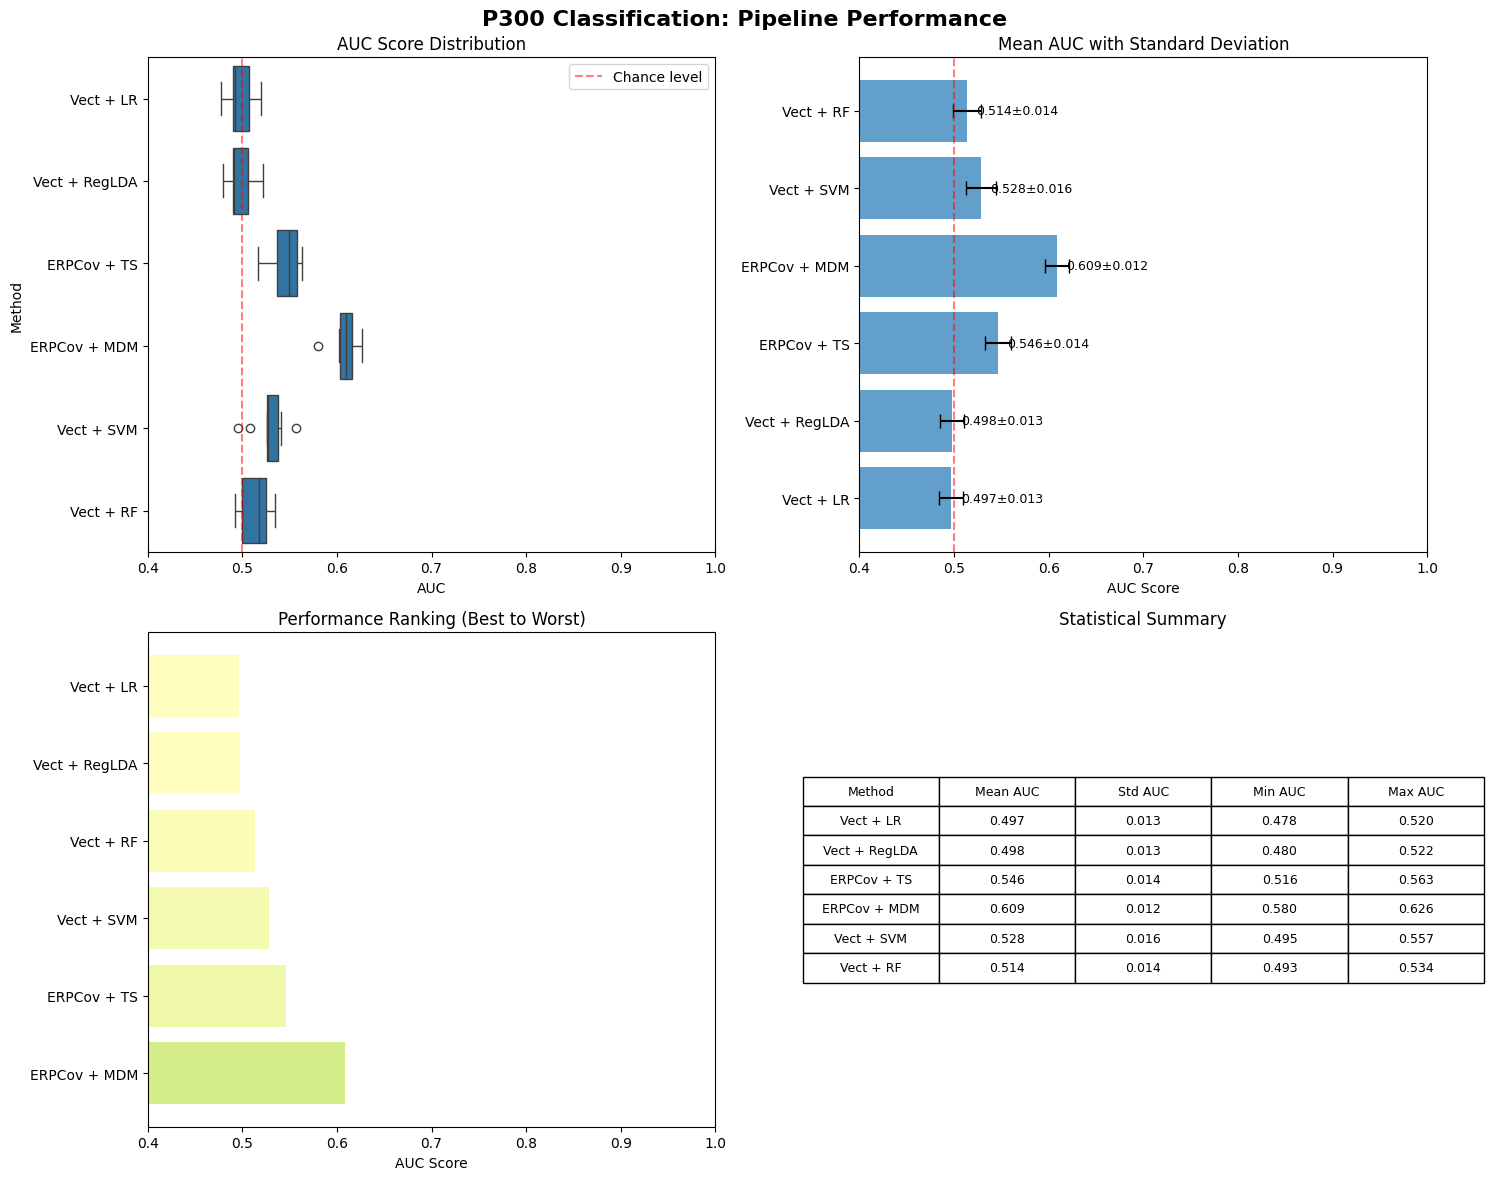

In [37]:
def plot_results(results_df, detailed_results, title="Pipeline Performance Comparison"):
    """
    Plot comprehensive results visualization
    """
    # Filter out methods with errors
    valid_methods = [name for name, result in detailed_results.items()
                    if 'error' not in result and result['mean_auc'] > 0]

    if not valid_methods:
        print("No valid results to plot")
        return

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Box plot of AUC scores
    valid_results = results_df[results_df['Method'].isin(valid_methods)]
    sns.boxplot(data=valid_results, y='Method', x='AUC', ax=ax1)
    ax1.set_title('AUC Score Distribution')
    ax1.set_xlim(0.4, 1.0)
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Chance level')
    ax1.legend()

    # 2. Bar plot of mean AUC with error bars
    methods = []
    means = []
    stds = []

    for method in valid_methods:
        methods.append(method)
        means.append(detailed_results[method]['mean_auc'])
        stds.append(detailed_results[method]['std_auc'])

    y_pos = np.arange(len(methods))
    ax2.barh(y_pos, means, xerr=stds, alpha=0.7, capsize=5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(methods)
    ax2.set_xlabel('AUC Score')
    ax2.set_title('Mean AUC with Standard Deviation')
    ax2.set_xlim(0.4, 1.0)
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax2.text(mean + 0.01, i, f'{mean:.3f}±{std:.3f}',
                va='center', fontsize=9)

    # 3. Performance ranking
    ranking = sorted(zip(methods, means), key=lambda x: x[1], reverse=True)
    rank_methods, rank_scores = zip(*ranking)

    colors = plt.cm.RdYlGn([score for _, score in ranking])
    ax3.barh(range(len(rank_methods)), rank_scores, color=colors)
    ax3.set_yticks(range(len(rank_methods)))
    ax3.set_yticklabels(rank_methods)
    ax3.set_xlabel('AUC Score')
    ax3.set_title('Performance Ranking (Best to Worst)')
    ax3.set_xlim(0.4, 1.0)

    # 4. Statistical summary table
    ax4.axis('tight')
    ax4.axis('off')

    table_data = []
    for method in valid_methods:
        result = detailed_results[method]
        table_data.append([
            method,
            f"{result['mean_auc']:.3f}",
            f"{result['std_auc']:.3f}",
            f"{result['scores'].min():.3f}",
            f"{result['scores'].max():.3f}"
        ])

    table = ax4.table(cellText=table_data,
                     colLabels=['Method', 'Mean AUC', 'Std AUC', 'Min AUC', 'Max AUC'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax4.set_title('Statistical Summary')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return ranking

# Plot results
ranking = plot_results(results_df, detailed_results, "P300 Classification: Pipeline Performance")

In [38]:
def evaluate_best_pipeline_on_test(pipelines, detailed_results, X_train, y_train, X_test, y_test):
    """
    Train the best pipeline on full training data and evaluate on test data
    """
    # Find best pipeline
    valid_results = {name: result for name, result in detailed_results.items()
                    if 'error' not in result and result['mean_auc'] > 0}

    if not valid_results:
        print("No valid pipelines to evaluate")
        return

    best_pipeline_name = max(valid_results.keys(),
                            key=lambda x: valid_results[x]['mean_auc'])
    best_pipeline = pipelines[best_pipeline_name]

    print(f"Best pipeline: {best_pipeline_name}")
    print(f"Cross-validation AUC: {valid_results[best_pipeline_name]['mean_auc']:.3f} (±{valid_results[best_pipeline_name]['std_auc']:.3f})")
    print("=" * 50)

    # Train on full training data
    print("Training on full training data...")
    best_pipeline.fit(X_train, y_train)

    # Evaluate on test data
    print("Evaluating on test data...")
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Test AUC: {test_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Target', 'Target']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Target', 'Target'],
                yticklabels=['Non-Target', 'Target'])
    plt.title(f'Confusion Matrix - {best_pipeline_name}\nTest AUC: {test_auc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return best_pipeline_name, test_auc

# Evaluate best pipeline on test data
best_name, test_auc = evaluate_best_pipeline_on_test(
    pipelines, detailed_results, X_train_clean, y_train_clean, X_test_clean, y_test_clean


SyntaxError: incomplete input (<ipython-input-38-3c7f925a6380>, line 52)